In [28]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import fathon
from fathon import fathonUtils as utils
from multiprocessing import Pool
from scipy.stats import linregress
data_folder = 'path/to/data/folder'
symbol_list = sorted(['FB1', 'JB1', 'XM1', 'TY1', 'TU1', 'RX1', 'YM1', 'G_1', 'KE1', 'FV1', 'US1', 'DU1'])  # symbols for T71 USB Drive
window_sizes = utils.linRangeByStep(10, 1000, step=20)
polynomial_order = 2
import matplotlib.pyplot as plt
num_processes = 4  # Set the number of processes for parallelization
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'



In [2]:
base_path = '/media/ak/T7/August11th2022Experiments'
# the files in exp_input_path, have more variables in them like this 'micro_price', 'price_imbalance', 'pct_change_micro_price',
#        'weighted_activity_spread', 'GK_vol', 'arrival_rates',
#        'returns_normalised', 'returns_mix_max', 'skew', 'kurt',
#        'median_traded_volume']
exp_input_path = os.path.join(base_path, 'ExperimentInputFiles')
hurstDicts = os.path.join(base_path, 'HurstDicts')
InfoClockDataFrames = os.path.join(base_path, 'InfoClockDataFrames')
# the symbol files in exp_one_path, contain files with ['micro_price_change', 'arrival_rates', 'gk_vol', 'median_traded_volume', 'tick']


In [3]:
symbol = 'FB1'
hurstSymbolPath = os.path.join(hurstDicts, str(symbol))
hurstFiles = [f for f in os.listdir(hurstSymbolPath) if str('HurstD') in f] # these are mixed symbol files
rhoFiles = [f for f in os.listdir(hurstSymbolPath) if str('Rho') in f] # these are mixed symbol files


In [112]:
idx = 2
rho_Df = pd.DataFrame()

for idx,_ in enumerate(rhoFiles):
    filePathRho = os.path.join(hurstSymbolPath, rhoFiles[idx])
    
    read_pickle = pd.read_pickle(filePath)
    index =(list(read_pickle.keys()))[0]
    rhoDf[index] = (read_pickle[index])

#     print(read_pickle.keys())
#     index =(list(read_pickle.keys()))[0]
#     hurstDf[index] = (read_pickle[index])

In [63]:
read_pickle.keys()

dict_keys(['n', 'F', 'H', 'H_intercept'])

In [94]:
F_Df = pd.DataFrame()
H_Df = dict()
H_intercept_Df = dict()
for idx, _ in enumerate(hurstFiles):
    
    filePathHurst = os.path.join(hurstSymbolPath, hurstFiles[idx])
    H_Df[idx] = (pd.read_pickle(filePathHurst)['H'])
    H_intercept_Df[idx]= pd.read_pickle(filePathHurst)['H_intercept']
    F_Df[idx] = pd.read_pickle(filePathHurst)['F']

In [95]:
H_Df = pd.DataFrame.from_dict(H_Df.values())

In [99]:
H_intercept_Df = pd.DataFrame.from_dict(H_intercept_Df.values())

In [86]:
def replace_zero_columns_with_median(col):
    if np.all(col == 0.0):
        left_indices = [max(col.name - 3, 0), max(col.name - 2, 0), max(col.name - 1, 0)]
        right_indices = [min(col.name + 1, len(df.columns) - 1), min(col.name + 2, len(df.columns) - 1), min(col.name + 3, len(df.columns) - 1)]
        combined_indices = left_indices + right_indices
        combined_columns = df[combined_indices]
        median = combined_columns.median(axis=1)
        col = median
    return col

def replace_nan_with_median(x):
    if pd.isna(x):
        row, col = x.index, x.columns.get_loc(x.name)
        before_index = max(col - 2, 0)
        after_index = min(col + 1, len(df.columns) - 1)

        before_value = df.iloc[row, before_index]
        after_value = df.iloc[row, after_index]

        median = np.median([before_value, after_value])

        # Make sure median is not NaN (in case both before and after values are NaN)
        if not pd.isna(median):
            return median

    return x

In [83]:
# Apply the custom function to each row
df = F_Df.apply(replace_zero_columns_with_median, axis=0)


In [100]:
# Apply the custom function to each element in the DataFrame
Hdf = H_Df.stack().apply(replace_nan_with_median).unstack()
HInterceptDF = H_intercept_Df.stack().apply(replace_nan_with_median).unstack()

In [21]:
rho_median = rhoDf.median(axis=1).values
# Check if there are NaN or Inf values
if np.isnan(n).any() or np.isnan(rho_median).any() or np.isinf(n).any() or np.isinf(rho_median).any():
    print("Warning: NaN or Inf values found in the input data.")

/home/ak/anaconda3/envs/timeSeries/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


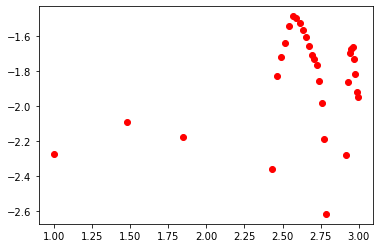

In [25]:
# Calculate the DCCA coefficient
log_n = np.log10(n + 1e-10)
log_rho = np.log10(rho_median + 1e-10)
# coefficients = np.polyfit(log_n, log_rho, 1)  # Fit a 1-degree (linear) polynomial
# slope = coefficients[0]
# intercept = coefficients[1]

# Plot the original data and the fitted line
plt.plot(log_n, log_rho, 'ro', label='Data')
# plt.plot(log_n, slope * log_n + intercept, 'b-', label=f'Fitted line (slope={slope:.2f})')
# plt.xlabel('Log10(Window Sizes)')
# plt.ylabel('Log10(Cross-Correlation Index (rho))')
# plt.title('DCCA Cross-Correlation Between Median Volume Traded and Arrival Rate of Trades')
# plt.legend()
# plt.grid(True)
# plt.show()

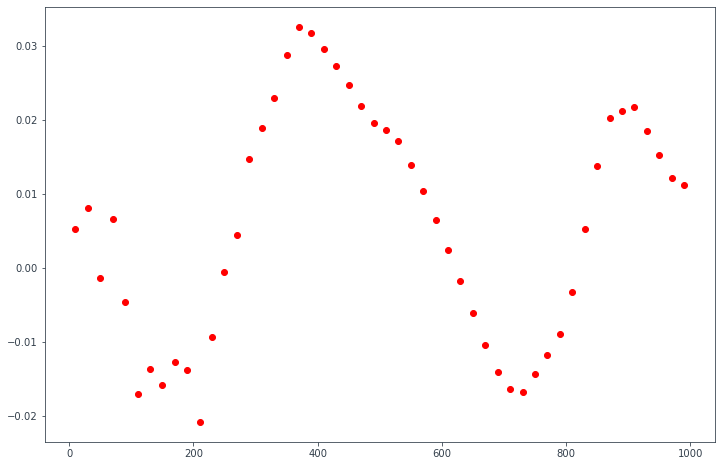

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(n, rho_median, 'ro', label='Data')

In [110]:
# H, H_intercept = pydcca.fitFlucVec()

# plt.plot(np.log(n), np.log(F), 'ro')
# plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
# plt.xlabel('ln(n)', fontsize=14)
# plt.ylabel('ln(F(n))', fontsize=14)
# plt.title('DCCA', fontsize=14)
# plt.legend(loc=0, fontsize=14)
# plt.show()


0       4.495756
1      12.084850
2      18.849855
3      25.939617
4      33.190855
5      40.001020
6      46.569902
7      53.457968
8      60.216181
9      66.596714
10     72.456634
11     77.769047
12     83.009342
13     88.024546
14     92.772331
15     97.233641
16    101.712987
17    105.941214
18    109.887015
19    113.536150
20    116.959257
21    120.478096
22    123.885619
23    127.191832
24    130.399571
25    133.634689
26    137.441413
27    141.104498
28    144.677217
29    148.418776
30    152.237816
31    156.018197
32    159.758588
33    163.457916
34    167.113616
35    170.446648
36    173.744295
37    177.057630
38    180.579914
39    184.097826
40    187.715808
41    191.411636
42    195.159060
43    198.759039
44    202.397539
45    206.090910
46    209.845596
47    213.533161
48    217.123688
49    220.742230
dtype: float64

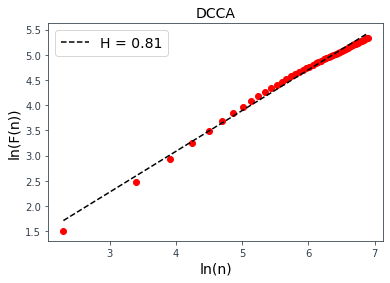

In [132]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
H_intercept =HInterceptDF.mean().values[0]
H =Hdf.mean().values[0]
F =df.mean(axis=1)

plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k--', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

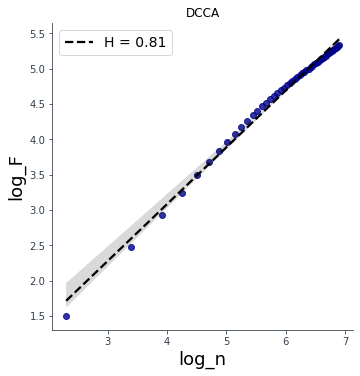

In [151]:
# Calculate log values
log_n = np.log(n)
log_F = np.log(F)

# Prepare the data in a Pandas DataFrame
data = pd.DataFrame({'log_n': log_n, 'log_F': log_F})

# Create a Seaborn lmplot with custom axis labels and legend
plot = sns.lmplot(x='log_n', y='log_F', data=data, scatter_kws={'color': 'darkblue'}, line_kws={'color': 'black', 'linestyle': '--'} )

# Customize axis labels and font size
plot.set(xlabel='ln(n)', ylabel='ln(F(n))', title='DCCA')
plot.set_xlabels(fontsize=18)
plot.set_ylabels(fontsize=18)

# Add custom legend
legend_text = 'H = {:.2f}'.format(H)
plot.ax.legend([legend_text], fontsize=14)

# Show the plot
plt.show()

In [118]:
H = Hdf.median()
H_intercept = HInterceptDF.median()

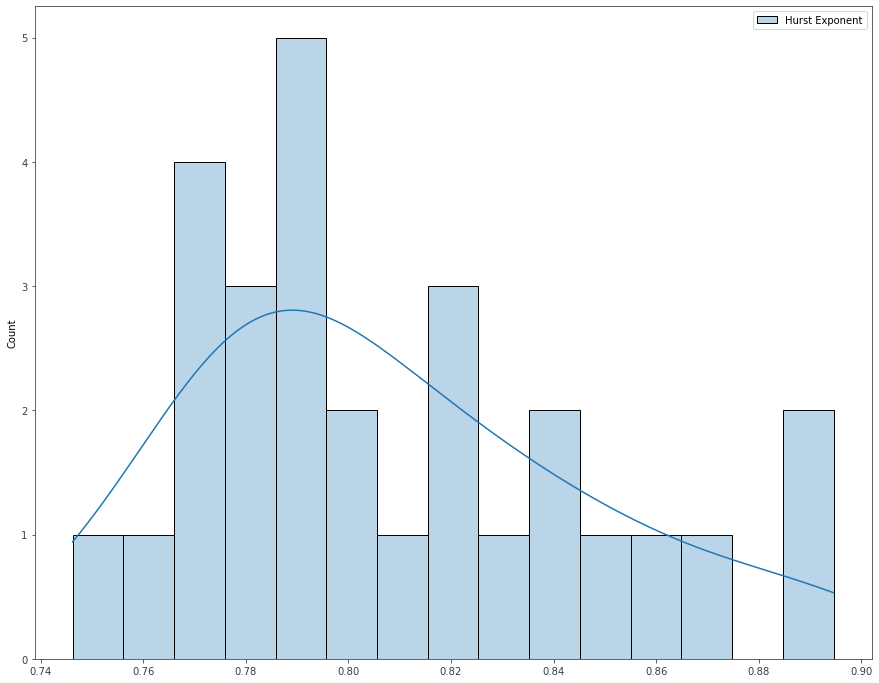

In [176]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12)) # Set the size of the figure
# Create a NumPy array
data = Hdf.values
# Set the number of bins and custom legend value
num_bins = 15
custom_legend_value = "Hurst Exponent"
# Increase x-ticks and y-ticks font sizes

# Create a Seaborn histogram with a custom number of bins and a KDE plot
ax = sns.histplot(data, kde=True, bins=num_bins, label=custom_legend_value, color='blue', alpha=0.3)
plot.ax.tick_params(axis='both', labelsize=16)
# # Add a Seaborn KDE plot with a custom label
# sns.kdeplot(data, label="KDE", color='blue', ax=ax)

# Show the legend
ax.legend()



# Show the plot
plt.show()
# In this example, we first import the necessary libraries (NumPy, Seaborn, and Matplotlib) and create a NumPy array containing 1000 random values from a normal distribution.

# We then set the number of bins and custom legend value for the histogram. We use the sns.histplot() function to create a histogram with the specified number of bins, and include a KDE plot by setting the kde=True parameter. We also set the label parameter to the custom legend value.

# Next, we add a standalone Seaborn KDE plot with a custom label using the sns.kdeplot() function.

# We use the ax.legend() function to display the legend with the custom values, and finally use the plt.show() function to display the plot.

# Replace the data variable with your own NumPy array, and customize the num_bins and custom_legend_value variables to create a histogram and KDE plot for your specific data with the desired legend and bins.








<Figure size 1080x864 with 0 Axes>

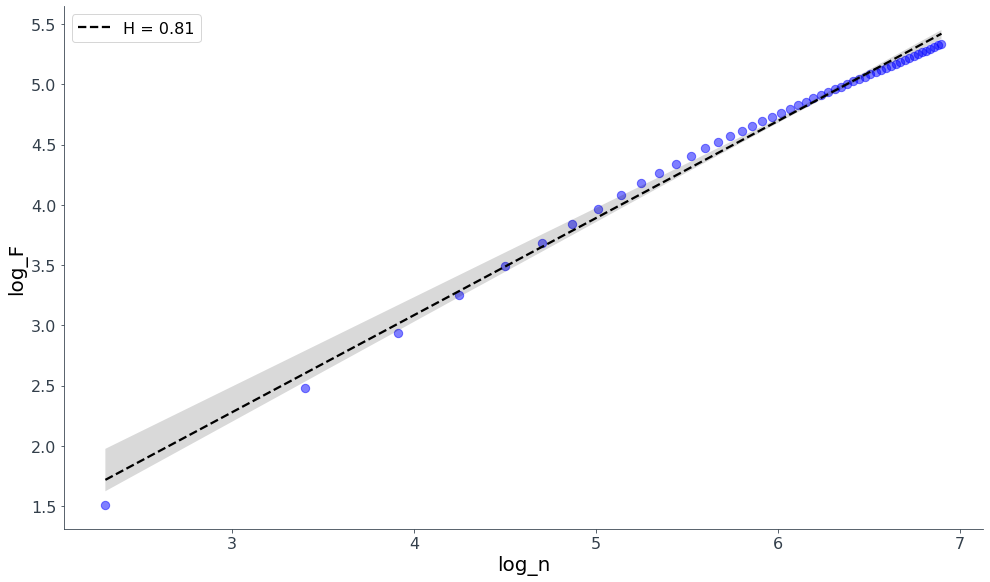

In [174]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
#Calculate log values
log_n = np.log(n)
log_F = np.log(F)
plt.figure(figsize=(15, 12)) # Set the size of the figure
# Prepare the data in a Pandas DataFrame
data = pd.DataFrame({'log_n': log_n, 'log_F': log_F})

# Create a Seaborn lmplot with custom axis labels and legend
plot = sns.lmplot(x='log_n', y='log_F', data=data, 
                  scatter_kws={'color': 'blue', 's': 70, 'alpha': 0.5}, 
                  line_kws={'color': 'black', 'linestyle': '--'} ,height=8, aspect=1.7)

# Customize axis labels and font size

_=plot.set(xlabel='ln(n)', ylabel='ln(F(n))', title='')
_=plot.set_xlabels(fontsize=20)
_=plot.set_ylabels(fontsize=20)

# Increase x-ticks and y-ticks font sizes
_ = plot.ax.tick_params(axis='both', labelsize=16)

# Add custom legend
legend_text = 'H = {:.2f}'.format(H)
_ = plot.ax.legend([legend_text], fontsize=16)

# Save the plot to a file
dcca_plot_filename = "_".join((symbol,'DCCA_plot.png'))
_=plt.savefig(os.path.join('/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures', dcca_plot_filename), dpi=300, bbox_inches='tight')

# Show the plot
_=plt.show()
